<a href="https://colab.research.google.com/github/maciejskorski/beta_tails/blob/main/Beta_SubGamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berstein Bounds for Beta Distribution

In [199]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [1]:
from scipy.special import hyp1f1
from scipy.optimize import root_scalar
import numpy as np

def beta_subgauss(a,b):
  ''' variance for sub-gaussian approx of beta distribution
      based on https://arxiv.org/pdf/1705.00048.pdf '''
  f = lambda x: np.log(hyp1f1(a,a+b,x)) - 0.5*x*a*1/(a+b)*( 1 + hyp1f1(a+1,a+b+1,x) / hyp1f1(a,a+b,x) )
  x0 = root_scalar(f,bracket=[0.01,1000],method='bisect').root
  v2 = a*1/((a+b)*x0)*(hyp1f1(a+1,a+b+1,x0) / hyp1f1(a,a+b,x0)-1)
  return v2

def beta_variance(a,b):
  return a*b * 1/ (a+b)**2 * 1/(a+b+1)

def beta_subgamma(a,b):
  ''' variance and scale for sub-gamma approx of beta distribution 
      based on: '''
  v2 = beta_variance(a,b)
  c = max((a-b)*1/(a+b)*1/(a+b+1),v2**0.5)
  return v2,c

print(beta_subgauss(5,5.01))
print(beta_subgamma(5,5.01))

0.022706627678676896
(0.022706607674773026, 0.15068711847657393)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, '$\\delta$')

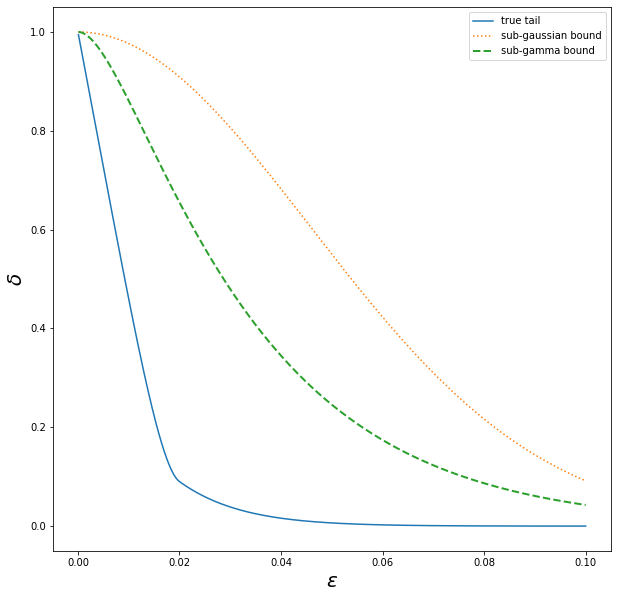

In [32]:
from matplotlib import pyplot as plt
from scipy.stats import beta
import numpy as np

a,b = 2,98 # params of your choice
mean = a/(a+b)

v2_gauss = beta_subgauss(a,b)
v2_gamma,c_gamma = beta_subgamma(a,b)

eps = np.linspace(1e-4,0.1,1000)

plt.figure(figsize=(10,10))

tail_true = beta(a,b).cdf(mean-eps) + (1-beta(a,b).cdf(mean+eps))
tail_sub_gauss = np.exp(- eps**2 / (2*v2_gauss) )
tail_sub_gamma = np.exp(- eps**2/(2*v2_gamma + 2*eps*c_gamma ))

plt.plot(eps,tail_true,label='true tail')
plt.plot(eps,tail_sub_gauss,':',label='sub-gaussian bound')
plt.plot(eps,tail_sub_gamma,'--',linewidth=2,label='sub-gamma bound')
plt.legend()
plt.xlabel('$\epsilon$',fontsize=20)
plt.ylabel('$\delta$',fontsize=20)